## Work on real Merian image
1. Most things are the same in the previous notebook `Merian-tractor-SEP-blob-by-blob.ipynb`.

2. The image `c4d_210307_021334_osj_N708_wide.fits` is not background-subtracted. In `Merian-raw-data-process.ipynb`, I (roughly) estimated a background and subtracted. I think we should discuss about background subtraction & flux calibration in more details. 

    **Update: the keyword `SKYSUB` in image header is the value of sky background. I just subtract this value. The image is scaled to ZP=27.0**


3. In order to fit Merian data with HSC i-band as reference, the i-band output source should be translated to Merian pixel_scale/zeropoint/etc. 

4. I made some updates to `kuaizi.tractor.utils.tractor_blob_by_blob`. Now we can freeze only "b/a" and "position angle" but not effective radius when fitting. In order to do this, use `freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'shape.re': False, 'sersicindex': True}`. 

5. The Merian N708 filter is dubbed as `N`. To get the fitting results, use `model_dict['N']` and `getTargetProperty(model_dict['N'], wcs=merian_data.wcs, pixel_scale=0.27, zeropoint=27)`. 

#### Notes on data
Directory: `/tigress/MERIAN/merian/cosmos_stack`

Suffix: image (`osj`), data quality (`osd`), and weights (`osw`)

Cutout is made in `Merian-raw-data-process.ipynb`

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [4]:
obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap_test.fits')
obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                              '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
                             ) for file in obj_cat['dir']]

### Step-by-step

In [5]:
from astropy.convolution import Gaussian2DKernel

In [183]:
channels = list('grizy') + ['N708', 'N540']

obj = obj_cat[16]
obj_id = obj['ID']


cutout = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}.fits')) for filt in 'grizy']
cutout += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_deepCoadd.fits")) for filt in channels[-2:]]

psf_list = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}_psf.fits')) for filt in 'grizy']
psf_list += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_psf.fits")) for filt in channels[-2:]]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [184]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
hsc_data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels) #  
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

# merian_hdu = fits.open('../cosmos_test_1/1/226984/merian/merian_226984_N708.fits')
# merian_data = Data(images=merian_hdu[1].data[np.newaxis, :, :], 
#                    weights=merian_hdu[3].data[np.newaxis, :, :], 
#                    wcs=wcs.WCS(merian_hdu[1].header), 
#                    psfs=[merian_hdu[4].data], channels='N')

In [185]:
images[3].shape

(89, 89)

Text(0.5, 1.0, 'Merian N708')

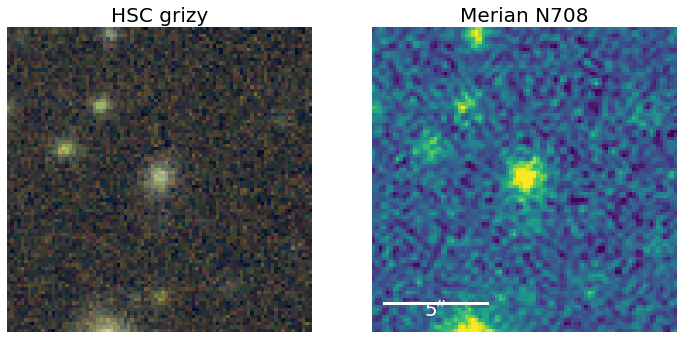

In [188]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    hsc_data.images[...],
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(img_rgb, origin='lower', alpha=1)
ax1.axis('off')
ax1.set_title('HSC grizy', fontsize=20)

ax2 = display_single(hsc_data.images[-1], ax=ax2, pixel_scale=0.168)
ax2.axis('off')
ax2.set_title('Merian N708', fontsize=20)

In [189]:
from kuaizi.tractor.utils import makeCatalog, tractor_hsc_sep_blob_by_blob, getTargetProperty
import sys
sys.path.append('/home/jiaxuanl/software/astrometry.net-0.89')
sys.path.append('/home/jiaxuanl/Research/Packages/tractor/')

### `cosmos_43158180737349885` i-band
    Detected 6 objects
# Total number of objects: 6
# Central object index in i-band: 0
# Progress: 1 / 6
# Progress: 2 / 6
# Progress: 3 / 6
# Progress: 4 / 6
# Progress: 5 / 6
# Progress: 6 / 6
# Global optimization: Chi2 improvement =  0.0040438175


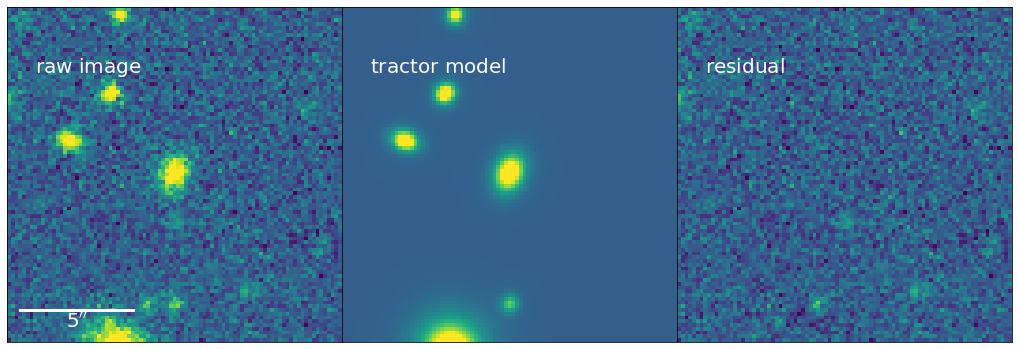

   The chi-square is 1.035658
SersicGalaxy at pixel (44.04, 44.41) with Flux: 28.0018 and Galaxy Shape: re=0.59, ab=0.65, phi=158.7, Sersic index 0.788


In [190]:
# Start fitting
# fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands
model_dict = {}

ref_filt = 'i'
model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
    obj, ref_filt, hsc_data.channels, hsc_data, 
    freeze_dict={'pos': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, # don't fix shape/sersic
    verbose=True, show_fig=True)

In [124]:
# import copy
# ref_source = copy.deepcopy(model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind])

# # Translate HSC coordinates into Merian coordinates
# x, y = merian_data.wcs.wcs_world2pix(*hsc_data.wcs.wcs_pix2world(ref_source.pos.x, ref_source.pos.y, 0), 0)
# ref_source.pos.x = float(x)
# ref_source.pos.y = float(y)
# ref_source.shape.re *= 0.168 / 0.27 # to Merian pixel scale

### `cosmos_43158180737349885` N540-band
    Detected 5 objects
# Total number of objects: 5
# Central object index in N540-band: 0
# Progress: 1 / 5
# Progress: 2 / 5
# Progress: 3 / 5
# Progress: 4 / 5
# Progress: 5 / 5
# Global optimization: Chi2 improvement =  0.014669776


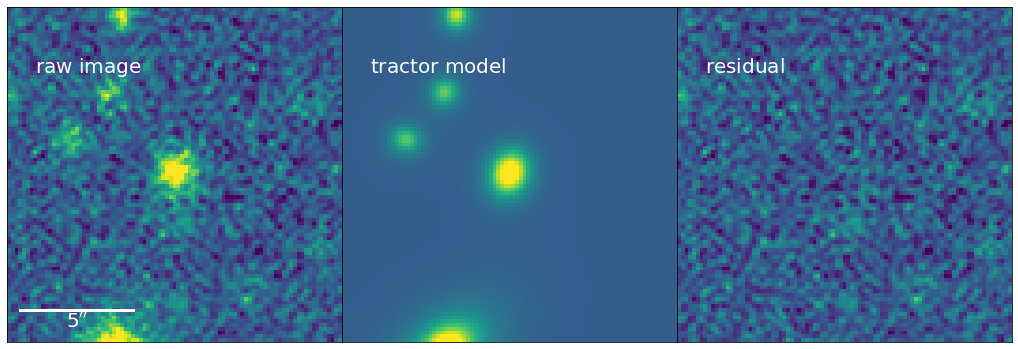

   The chi-square is 1.1037945
SersicGalaxy at pixel (44.04, 44.41) with Flux: 17.8009 and Galaxy Shape: re=0.58, ab=0.65, phi=158.7, Sersic index 0.788


In [194]:
import copy
ref_source = copy.deepcopy(model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind])


model_dict['N540'] = tractor_hsc_sep_blob_by_blob(
        obj, 'N540', hsc_data.channels, hsc_data, 
        ref_source=ref_source,
#         ref_source=None,
#         freeze_dict={'pos': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
        freeze_dict={'pos': False, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
        # Since the coordinate system of Merian is different from HSC, we don't fix position. 
        verbose=True, show_fig=True)

In [126]:
# _write_to_row(meas_cat[81], model_dict)

In [195]:
2.5 * np.log10(getTargetProperty(model_dict['N540'])['flux'] / getTargetProperty(model_dict['i'])['flux'])

-0.4918589415419585

In [193]:
(obj_cat['i_gaap_mag'] - obj_cat['N708_gaap_mag'])[6]

-0.08007528338663406

# Batch fitting (forced-photometry, blob-by-blob)

In [166]:
from kuaizi.tractor.utils import initialize_meas_cat, _write_to_row

In [167]:
# meas_cat = initialize_meas_cat(obj_cat)

### Tractor modeling for obj 0
### `cosmos_43158176442360746` i-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in i-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


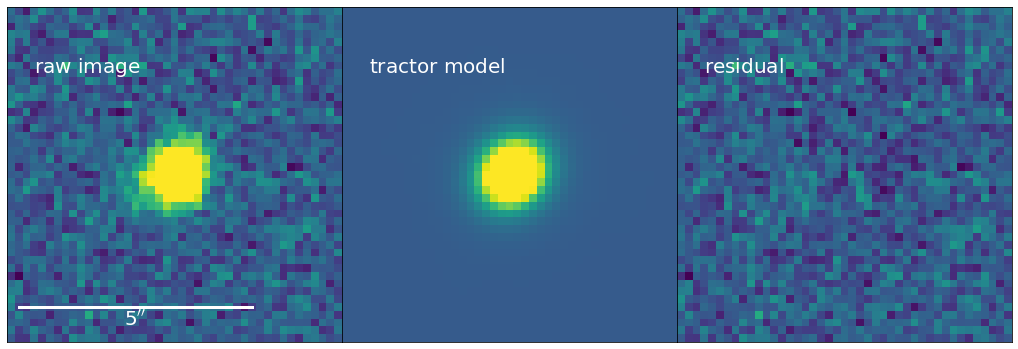

   The chi-square is 1.0823812
SersicGalaxy at pixel (21.41, 21.07) with Flux: 54.5678 and Galaxy Shape: re=0.30, ab=0.76, phi=130.5, Sersic index 1.563
### `cosmos_43158176442360746` g-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in g-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


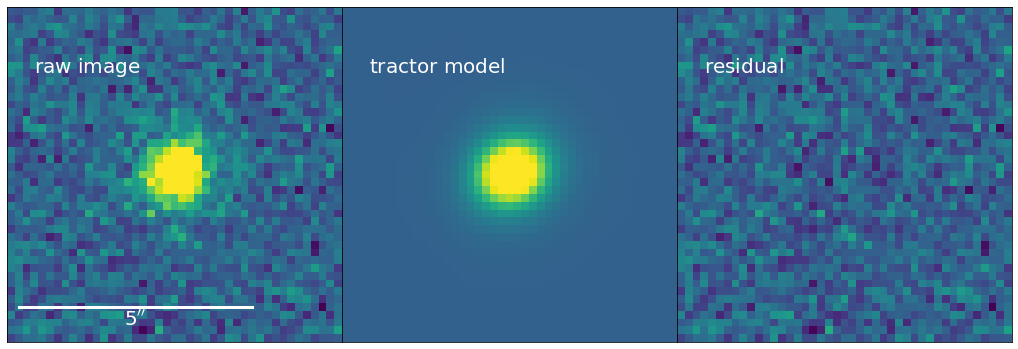

   The chi-square is 1.0733097
SersicGalaxy at pixel (21.28, 21.22) with Flux: 28.3271 and Galaxy Shape: re=0.36, ab=0.76, phi=130.5, Sersic index 1.563
### `cosmos_43158176442360746` r-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in r-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


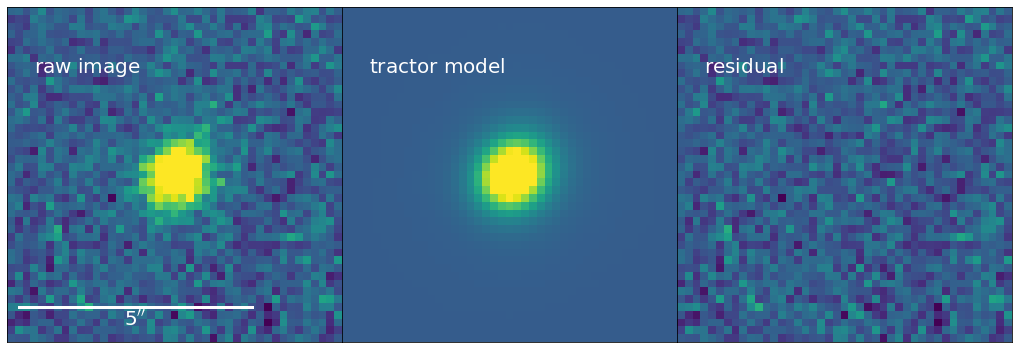

   The chi-square is 0.99956596
SersicGalaxy at pixel (21.41, 21.01) with Flux: 39.2842 and Galaxy Shape: re=0.25, ab=0.76, phi=130.5, Sersic index 1.563
### `cosmos_43158176442360746` z-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in z-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


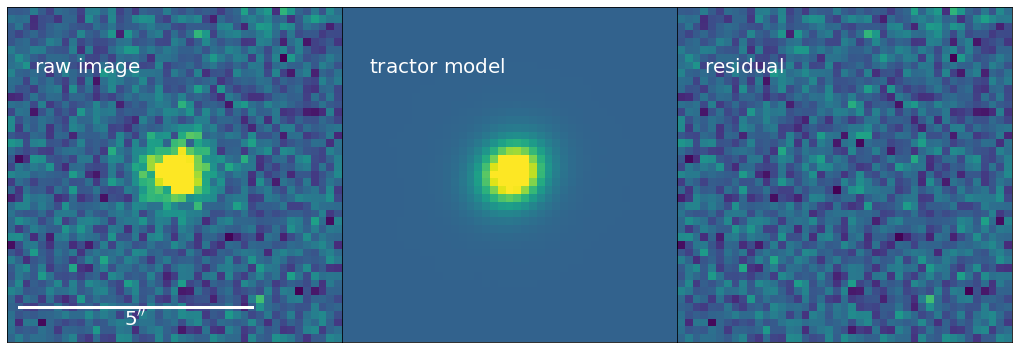

   The chi-square is 0.9753129
SersicGalaxy at pixel (21.33, 21.23) with Flux: 51.4138 and Galaxy Shape: re=0.32, ab=0.76, phi=130.5, Sersic index 1.563
### `cosmos_43158176442360746` y-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in y-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


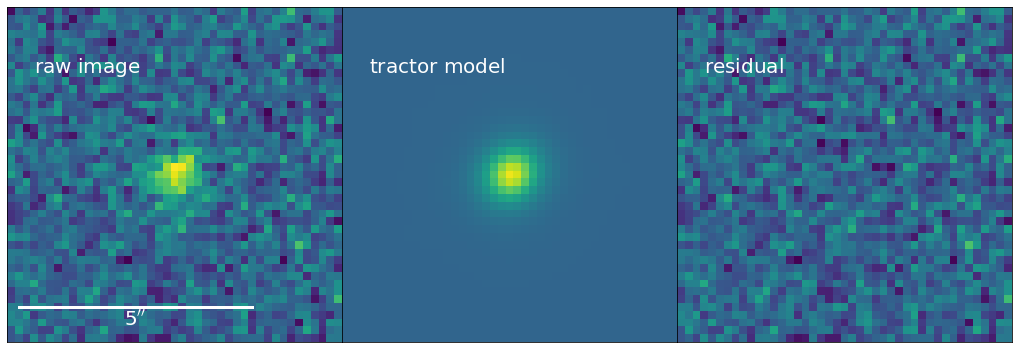

   The chi-square is 1.031402
SersicGalaxy at pixel (21.25, 21.02) with Flux: 55.9235 and Galaxy Shape: re=0.31, ab=0.76, phi=130.5, Sersic index 1.563
### `cosmos_43158176442360746` N708-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in N708-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


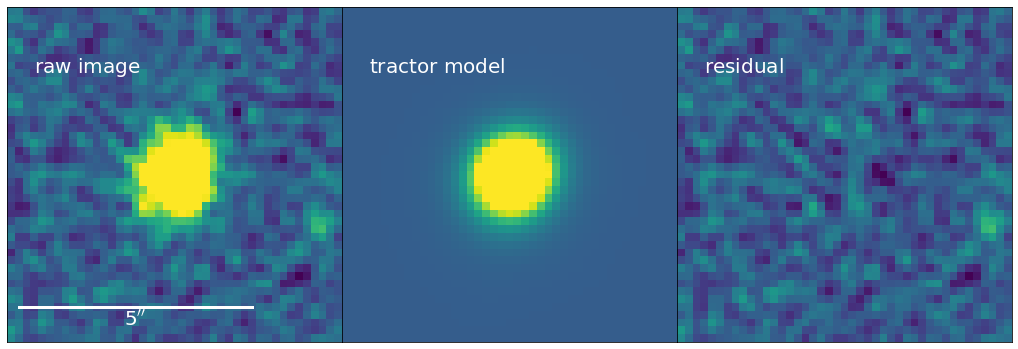

   The chi-square is 0.9875908
SersicGalaxy at pixel (21.44, 21.01) with Flux: 46.1439 and Galaxy Shape: re=0.29, ab=0.76, phi=130.5, Sersic index 1.563
### `cosmos_43158176442360746` N540-band
    Detected 1 objects
# Total number of objects: 1
# Central object index in N540-band: 0
# Progress: 1 / 1
# Global optimization: Chi2 improvement =  0.0


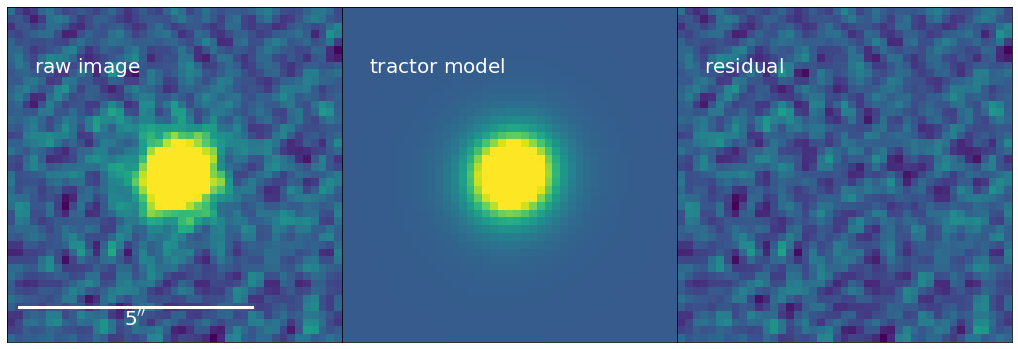

   The chi-square is 1.0112783
SersicGalaxy at pixel (21.34, 20.96) with Flux: 27.5094 and Galaxy Shape: re=0.27, ab=0.76, phi=130.5, Sersic index 1.563


In [197]:
channels = list('grizy') + ['N708', 'N540']

ref_filt = 'i'
forced_channels = [filt for filt in channels if filt != ref_filt]

for k, obj in enumerate(obj_cat[0:1]):
    print(f'### Tractor modeling for obj {k}')
    obj_id = obj['ID']

    cutout = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}.fits')) for filt in 'grizy']
    cutout += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_deepCoadd.fits")) for filt in channels[-2:]]
    psf_list = [fits.open(os.path.join(obj['dir'], f's18a_wide_{obj["ID"]}_{filt}_psf.fits')) for filt in 'grizy']
    psf_list += [fits.open(os.path.join(obj['dir'], f"{obj['PREFIX']}_{filt}_psf.fits")) for filt in channels[-2:]]

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout if len(hdu) > 1])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    
    # Start fitting
    model_dict = {}
    # fitting in the i-band first: then pass the i-band parameters of target galaxy to other bands 
    model_dict[ref_filt] = tractor_hsc_sep_blob_by_blob(
        obj, ref_filt, data.channels, data, 
        freeze_dict={'pos': False, 'shape.ab': False, 'shape.phi': False, 'sersicindex': False}, 
        # don't fix shape/sersic
        verbose=True, show_fig=True)

    for filt in forced_channels:
        pos = False# if filt == 'N' else True
        model_dict[filt] = tractor_hsc_sep_blob_by_blob(
            obj, filt, data.channels, data, 
            ref_source=model_dict[ref_filt].catalog[model_dict[ref_filt].target_ind],
            freeze_dict={'pos': pos, 'shape.ab': True, 'shape.phi': True, 'sersicindex': True}, 
            # don't fix shape/sersic
            verbose=True, show_fig=True)
    # Write to catalog
#     with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
#         pickle.dump(model_dict, f)

In [53]:
_write_to_row(meas_cat[81], model_dict)

ID,x,x_ivar,y,y_ivar,flux [6],flux_ivar [6],ab,ab_ivar,phi,phi_ivar,sersic,sersic_ivar,mag [6]
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
43158180737349578,20.131992420505696,2387.3701171875,20.204637008729026,2196.293212890625,0.4168569777204942 .. 1.4231366321744383,43742.76646983297 .. 43906.644890755924,0.8081650098332142,847.37744140625,145.80894182766892,0.02245868742465973,3.1811119987590892,39.56598663330078,23.22787314848449 .. 22.011487409727764


In [ ]:
# meas_cat.write('./Catalogs/tractor_test_output.fits')

---

In [134]:
meas_cat = Table.read('./Catalogs/tractor_test_output_0_200.fits')
obj_cat = Table.read('./Catalogs/COSMOS_cutouts_tractor_gaap_test.fits')
obj_cat['dir'] = [file.replace('/projects/MERIAN/poststamps/g09_broadcut', 
                              '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout'
                             ) for file in obj_cat['dir']]

In [135]:
(obj_cat['i_gaap_mag'] - obj_cat['N708_gaap_mag'])[81]

0.4579267208944735

In [136]:
meas_cat['mag'] = 22.5 - 2.5 * np.log10(meas_cat['flux'].data)

In [137]:
obj_cat['mag'] = np.hstack([obj_cat[f'{filt}_gaap_mag'].data[:, None] for filt in list('grizy') + ['N708']])

In [138]:
obj_cat['mag_tractor'] = 22.5 - 2.5 * np.log10(np.hstack(
    [obj_cat[f'{filt}_tractor_flux'].data[:, None] for filt in list('grizy') + ['N708']]))

Text(0, 0.5, 'Tractor')

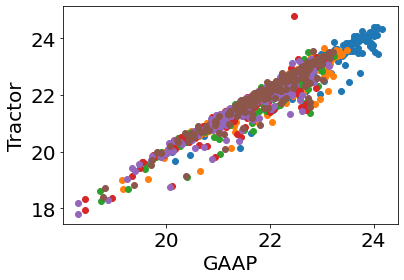

In [139]:
for i in range(6):
    plt.scatter(obj_cat['mag'][:, i], meas_cat['mag'][:, i])

plt.xlabel('GAAP')
plt.ylabel('Tractor')

Text(0, 0.5, 'GAAP - Tractor')

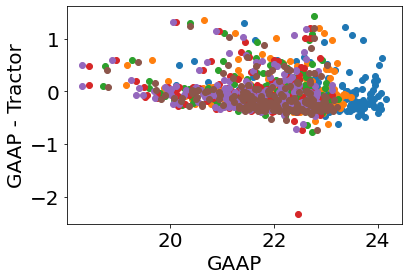

In [140]:
for i in range(6):
    plt.scatter(obj_cat['mag'][:, i], obj_cat['mag'][:, i] - meas_cat['mag'][:, i])

plt.xlabel('GAAP')
plt.ylabel('GAAP - Tractor')

01234 5
grizy N708

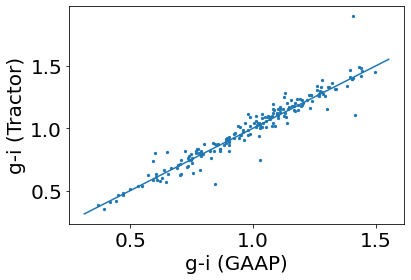

In [142]:
plt.scatter(obj_cat['mag'][:, 0] - obj_cat['mag'][:, 2], 
            meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2],
            s=5)

plt.xlabel('g-i (GAAP)')
plt.ylabel('g-i (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

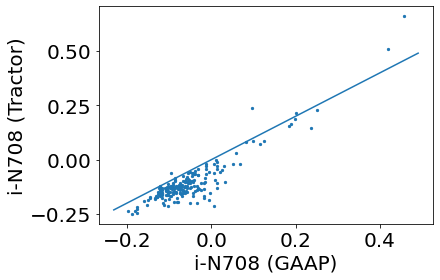

In [143]:
plt.scatter(obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5], 
            meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5], 
            s=5)

plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

In [144]:
iN708_gaap = obj_cat['mag'][:, 2] - obj_cat['mag'][:, 5]
iN708_tractor = meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5]

In [145]:
iN708_gaap[33], iN708_tractor[33]

(0.006813865327494284, -0.21174693736248784)

In [147]:
np.where(np.abs(iN708_gaap - iN708_tractor) > 0.1)

(array([  6,  16,  23,  27,  31,  33,  52,  59,  64,  66,  69,  73,  81,
        110, 113, 116, 117, 123, 139, 140, 151, 157, 159, 176, 194]),)

In [64]:
obj_cat['mag'][81]

array([23.05240099, 22.35557233, 22.20712019, 22.0004899 , 22.20414872,
       21.74919347])

In [16]:
(22.20712019 - 21.74919347)

0.4579267199999997

In [17]:
meas_cat['mag'][81]

array([23.22787315, 22.54838364, 22.67220946, 22.18725689, 22.50958223,
       22.01148741])

In [277]:
meas_cat['mag'][81]

array([23.22787315, 22.54838364, 22.67220946, 22.18725689, 22.50958223,
       22.01330684])

In [279]:
(22.67220946 - 22.01330684)

0.6589026200000028

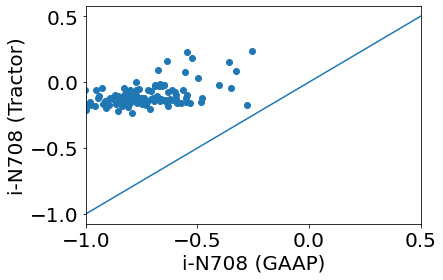

In [207]:
plt.scatter(obj_cat['mag_tractor'][:, 2] - obj_cat['mag_tractor'][:, 5], 
            meas_cat['mag'][:, 2] - meas_cat['mag'][:, 5])

plt.xlim(-1, 0.5)
plt.xlabel('i-N708 (GAAP)')
plt.ylabel('i-N708 (Tractor)')

x = plt.gca().get_xlim()
x = np.linspace(*x, 100)
plt.plot(x, x)

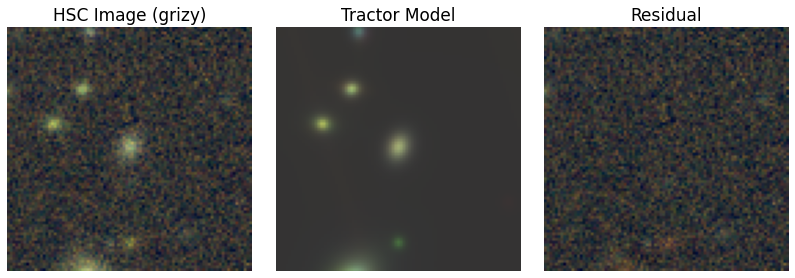

In [180]:
# ### Make figures into a PDF file (slow)
# from fpdf import FPDF
# pdf = FPDF()
# pdf.add_page()
# for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
#     pdf.image(image, 21, 11 + k * 55, 167, 55)
# pdf.output(obj_name + "_sep_tractor.pdf", "F")

# Visualize our model
from kuaizi.tractor.utils import HiddenPrints
with HiddenPrints():
    model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

model_rgb = scarlet.display.img_to_rgb(
    model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

res_rgb = scarlet.display.img_to_rgb(
    data.images - model_img,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(img_rgb, origin='lower')
ax2.imshow(model_rgb, origin='lower')
ax3.imshow(res_rgb, origin='lower')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

ax1.set_title('HSC Image (grizy)', fontsize=17)
ax2.set_title('Tractor Model', fontsize=17)
ax3.set_title('Residual', fontsize=17)

plt.subplots_adjust(wspace=0.1)
# plt.savefig(obj_name + '_sep_tractor_rgb.png', 
#             bbox_inches='tight', 
#             metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})


#clear_output()
#plt.close()